# Chapter 2 — How to get started: CO₂ exchange between atmosphere and ocean

**Based on chapter 2:** J.C.G. Walker, *Numerical Adventures with Geochemical Cycles*, Oxford University Press, 1991.

---

## 2.1 The Physical Problem

As a simple first example of a global geochemical simulation, Walker considers the exchange of carbon dioxide between the ocean and the atmosphere. The key data (from Broecker and Peng, 1982):

| Quantity | Value |
|---|---|
| Atmospheric CO₂ content | $N_a = 5.6 \times 10^{16}$ moles |
| Annual atmosphere → ocean flux | $F = 6.5 \times 10^{15}$ moles/yr |
| Residence time $\tau = N_a / F$ | **8.6 years** |

The ocean is treated as a very large reservoir whose CO₂ content does not change significantly. The flux *from* the atmosphere *to* the ocean is proportional to the atmospheric CO₂ content, while the *return* flux from the ocean is taken as constant (because the ocean is so large).

We normalise the atmospheric CO₂ content to its equilibrium value, defining:

$$
p = \frac{\text{CO}_2 \text{ content}}{\text{equilibrium CO}_2 \text{ content}}
$$

so that $p = 1$ at equilibrium. The governing equation becomes:

$$
\frac{dp}{dt} = \frac{1 - p}{\tau}
$$

where $\tau = 8.6$ years is the residence time.

**Physical interpretation:** The source term (ocean → atmosphere) is the constant $1/\tau$. The sink term (atmosphere → ocean) is $-p/\tau$, proportional to the current atmospheric level. When $p > 1$, there is more CO₂ than at equilibrium, so the net flux is into the ocean (dp/dt < 0). When $p < 1$, the atmosphere is depleted and the net flux is out of the ocean.

### The scenario

Walker poses the question: suppose we suddenly inject a large pulse of fossil-fuel CO₂ into the atmosphere, raising $p$ to some initial value $p_0 = 5$ (five times the equilibrium level). How does the atmosphere recover?

This has an **analytical solution** (simple exponential decay towards equilibrium):

$$
p(t) = 1 + (p_0 - 1)\, e^{-t/\tau}
$$

---

## 2.2 Numerical methods

Walker's pedagogical goal in Chapter 2 is to introduce two fundamental numerical methods for solving ordinary differential equations, and to show how the choice of method and time step dramatically affects stability and accuracy.

### Forward (Explicit) Euler method

The simplest approach: evaluate the derivative at the *current* time and step forward:

$$
p_{n+1} = p_n + \Delta t \cdot f(t_n,\, p_n)
$$

For our equation $f(t, p) = (1 - p)/\tau$, this gives:

$$
p_{n+1} = p_n + \Delta t \cdot \frac{1 - p_n}{\tau}
$$

**Stability criterion:** The forward Euler method is stable only when $\Delta t / \tau < 2$. For $\Delta t / \tau > 2$, the solution oscillates and blows up. Walker uses this dramatically to motivate the need for better methods.

### Reverse (Implicit) Euler method — Walker's preferred approach

Walker calls this the **"reverse Euler method"** and it is used throughout the book. Instead of evaluating the derivative at the current time, we evaluate it backwards at the *next* time step:

$$
p_{n+1} = p_n + \Delta t \cdot f(t_{n+1},\, p_{n+1})
$$

For our linear equation:

$$
p_{n+1} = p_n + \Delta t \cdot \frac{1 - p_{n+1}}{\tau}
$$

Solving for $p_{n+1}$:

$$
p_{n+1} = \frac{p_n + \Delta t / \tau}{1 + \Delta t / \tau}
$$

This method is **unconditionally stable**, it never blows up regardless of the time step size. This is why Walker advocates it for geochemical simulations, where one often wants to take large time steps over geological time scales.


---

## 2.3 Implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Physical parameters (Walker Ch.2, after Broecker & Peng 1982)
N_atm = 5.6e16      # moles CO2 in atmosphere
F_exchange = 6.5e15  # moles/yr atmosphere-ocean exchange flux
tau = N_atm / F_exchange  # residence time ≈ 8.6 years

print(f"Atmospheric CO₂:  {N_atm:.1e} moles")
print(f"Exchange flux:    {F_exchange:.1e} moles/yr")
print(f"Residence time:   τ = {tau:.2f} years")

Atmospheric CO₂:  5.6e+16 moles
Exchange flux:    6.5e+15 moles/yr
Residence time:   τ = 8.62 years


In [2]:
# The ODE: dp/dt = (1 - p) / tau
def dpdt(t, p, tau):
    """Rate of change of normalised atmospheric CO2."""
    return (1.0 - p) / tau

# Analytical solution for comparison
def analytical(t, p0, tau):
    """Exact solution: p(t) = 1 + (p0 - 1) * exp(-t/tau)"""
    return 1.0 + (p0 - 1.0) * np.exp(-t / tau)

In [3]:
# ============================================================
# Forward (Explicit) Euler Method
# ============================================================
def forward_euler(p0, tau, dt, t_end):
    """Walker's 'forward Euler' — explicit method."""
    t = np.arange(0, t_end + dt, dt)
    p = np.zeros_like(t)
    p[0] = p0
    for n in range(len(t) - 1):
        p[n+1] = p[n] + dt * (1.0 - p[n]) / tau
    return t, p

# ============================================================
# Reverse (Implicit) Euler Method — Walker's preferred method
# ============================================================
def reverse_euler(p0, tau, dt, t_end):
    """Walker's 'reverse Euler' — implicit method.
    
    From:  p_{n+1} = p_n + dt * (1 - p_{n+1}) / tau
    Solve: p_{n+1} = (p_n + dt/tau) / (1 + dt/tau)
    """
    t = np.arange(0, t_end + dt, dt)
    p = np.zeros_like(t)
    p[0] = p0
    r = dt / tau
    for n in range(len(t) - 1):
        p[n+1] = (p[n] + r) / (1.0 + r)
    return t, p

---

## 2.4 Experiment 1: Demonstrating instability of the forward Euler method

Walker's key lesson: the forward Euler method becomes unstable when $\Delta t > 2\tau$. With $\tau \approx 8.6$ years, a time step of $\Delta t = 10$ years already exceeds the stability limit ($10/8.6 \approx 1.16$, which is less than 2, so still stable but oscillatory). At $\Delta t = 20$ years ($20/8.6 \approx 2.3 > 2$), it blows up.

However, the reverse Euler method remains stable for *any* time step.

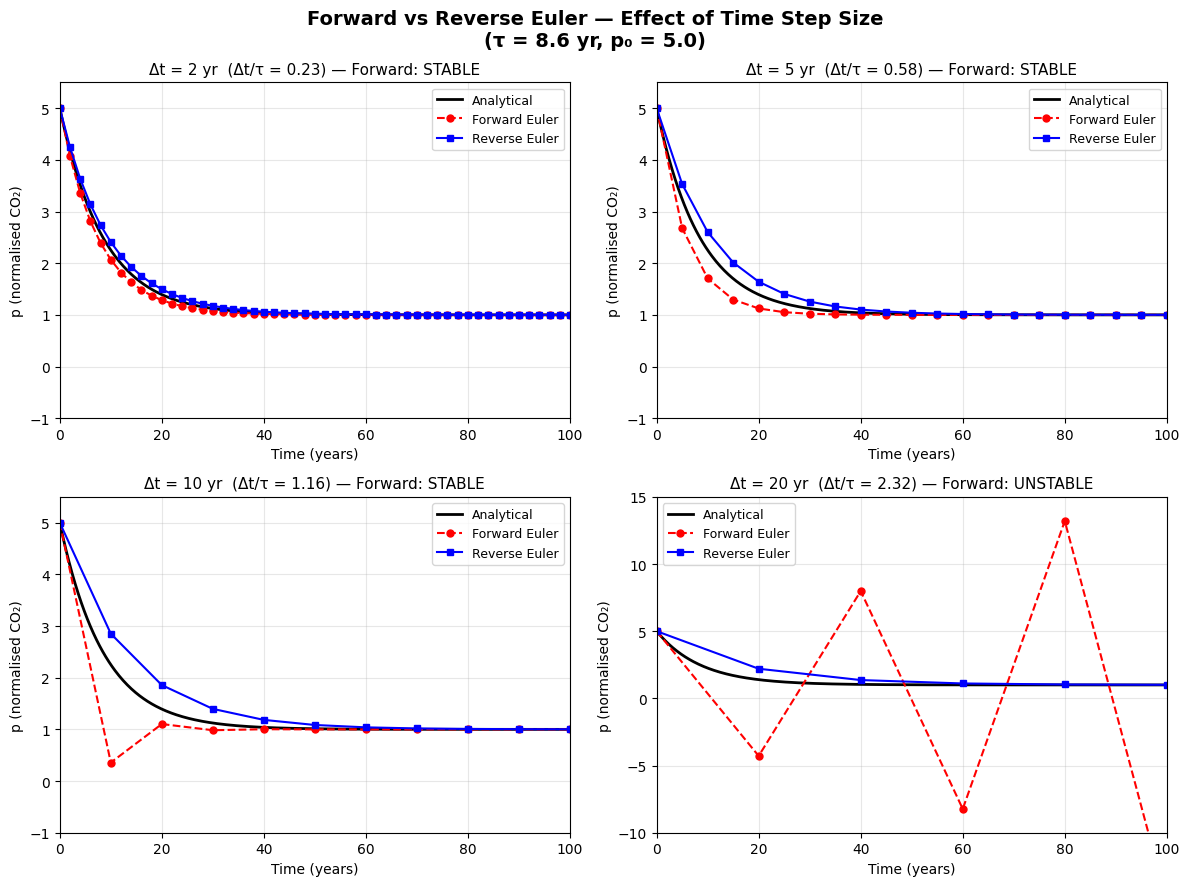

In [4]:
p0 = 5.0       # Initial perturbation: 5× equilibrium
t_end = 100.0   # Simulate 100 years

# Analytical (reference) solution
t_exact = np.linspace(0, t_end, 500)
p_exact = analytical(t_exact, p0, tau)

# Test several time steps to show stability behaviour
time_steps = [2, 5, 10, 20]  # years

fig, axes = plt.subplots(2, 2, figsize=(12, 9))
fig.suptitle('Forward vs Reverse Euler — Effect of Time Step Size\n'
             f'(τ = {tau:.1f} yr, p₀ = {p0})',
             fontsize=14, fontweight='bold')

for ax, dt in zip(axes.flat, time_steps):
    t_fwd, p_fwd = forward_euler(p0, tau, dt, t_end)
    t_rev, p_rev = reverse_euler(p0, tau, dt, t_end)
    
    ax.plot(t_exact, p_exact, 'k-', linewidth=2, label='Analytical')
    ax.plot(t_fwd, p_fwd, 'ro--', markersize=5, label='Forward Euler')
    ax.plot(t_rev, p_rev, 'bs-', markersize=5, label='Reverse Euler')
    
    ratio = dt / tau
    stability = 'STABLE' if ratio < 2 else 'UNSTABLE'
    ax.set_title(f'Δt = {dt} yr  (Δt/τ = {ratio:.2f}) — Forward: {stability}',
                fontsize=11)
    ax.set_xlabel('Time (years)')
    ax.set_ylabel('p (normalised CO₂)')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, t_end)
    
    # Set reasonable y-limits for unstable cases
    if ratio < 2:
        ax.set_ylim(-1, p0 + 0.5)
    else:
        # Clip to show the blow-up without losing the plot
        ax.set_ylim(-10, 15)

plt.tight_layout()
plt.show()

**Observations:**

- At $\Delta t = 2$ yr ($\Delta t/\tau = 0.23$): Both methods track the analytical solution well.
- At $\Delta t = 5$ yr ($\Delta t/\tau = 0.58$): Forward Euler shows slight overshoot; reverse Euler stays smooth.
- At $\Delta t = 10$ yr ($\Delta t/\tau = 1.16$): Forward Euler oscillates around equilibrium but eventually settles (marginally stable).
- At $\Delta t = 20$ yr ($\Delta t/\tau = 2.33$): **Forward Euler blows up!** The reverse Euler remains stable and slowly converges.

This is Walker's central message: the **reverse Euler method is the workhorse** for geochemical simulations because it is unconditionally stable.

---

## 2.5 Experiment 2: Accuracy comparison at small time steps

Both methods converge to the true solution as $\Delta t \to 0$, but with different errors. Let us examine the accuracy systematically.

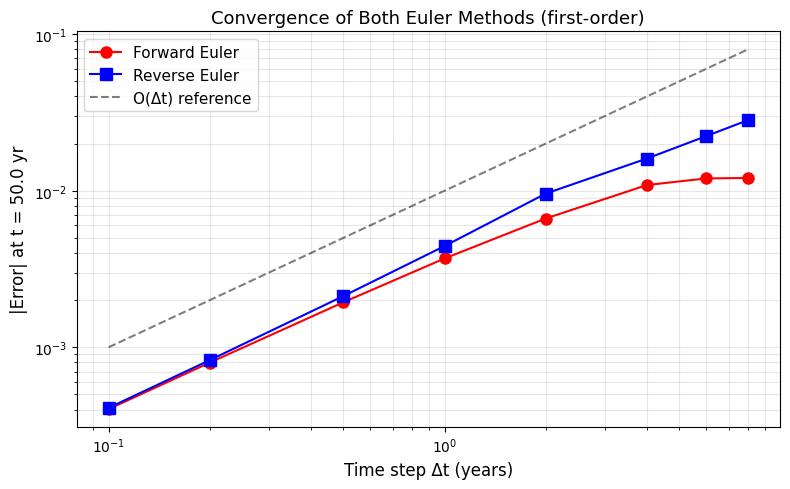

True solution at t=50.0: p = 1.012067

   Δt (yr)    Fwd Error    Rev Error     Δt/τ
---------------------------------------------
       0.1     4.03e-04     4.10e-04    0.012
       0.2     7.98e-04     8.28e-04    0.023
       0.5     1.94e-03     2.12e-03    0.058
       1.0     3.69e-03     4.43e-03    0.116
       2.0     6.65e-03     9.59e-03    0.232
       4.0     1.09e-02     1.60e-02    0.464
       6.0     1.20e-02     2.23e-02    0.696
       8.0     1.21e-02     2.82e-02    0.929


In [5]:
# Measure the error at t = 50 years for various time steps
t_eval = 50.0
p_true = analytical(t_eval, p0, tau)

dt_values = np.array([0.1, 0.2, 0.5, 1.0, 2.0, 4.0, 6.0, 8.0])
errors_fwd = []
errors_rev = []

for dt in dt_values:
    t_f, p_f = forward_euler(p0, tau, dt, t_eval)
    t_r, p_r = reverse_euler(p0, tau, dt, t_eval)
    errors_fwd.append(abs(p_f[-1] - p_true))
    errors_rev.append(abs(p_r[-1] - p_true))

fig, ax = plt.subplots(figsize=(8, 5))
ax.loglog(dt_values, errors_fwd, 'ro-', markersize=8, label='Forward Euler')
ax.loglog(dt_values, errors_rev, 'bs-', markersize=8, label='Reverse Euler')

# Reference line for first-order convergence
ax.loglog(dt_values, 0.01 * dt_values, 'k--', alpha=0.5, label='O(Δt) reference')

ax.set_xlabel('Time step Δt (years)', fontsize=12)
ax.set_ylabel(f'|Error| at t = {t_eval} yr', fontsize=12)
ax.set_title('Convergence of Both Euler Methods (first-order)', fontsize=13)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, which='both')
plt.tight_layout()
plt.show()

print(f"True solution at t={t_eval}: p = {p_true:.6f}")
print(f"\n{'Δt (yr)':>10} {'Fwd Error':>12} {'Rev Error':>12} {'Δt/τ':>8}")
print('-' * 45)
for dt, ef, er in zip(dt_values, errors_fwd, errors_rev):
    print(f"{dt:10.1f} {ef:12.2e} {er:12.2e} {dt/tau:8.3f}")

Both methods are **first-order accurate** ($O(\Delta t)$), as expected for Euler methods. The errors decrease linearly with the time step. However, the *direction* of the error differs: the forward Euler tends to undershoot (decay too fast), while the reverse Euler tends to overshoot (decay too slowly). We can call this a form of numerical diffusion.

---

## 2.6 Comparison with SciPy's adaptive solver

Modern scientific Python provides adaptive Runge-Kutta methods (e.g. RK45) that automatically adjust the step size to maintain a prescribed error tolerance. Walker's book predates these tools (he used the `BASIC` programming language without any libraries), but it is instructive to compare. In Chapter 9, we dive deeper into comparing Walker's simple procedures with modern solvers in `SciPy`.

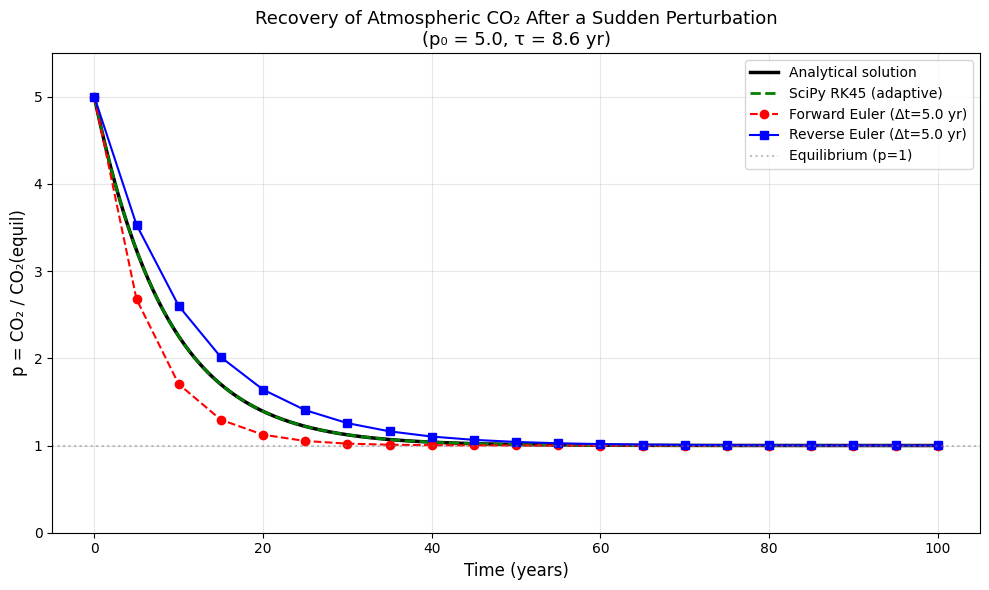

SciPy solver used 920 function evaluations with 154 steps.
Max |SciPy - Analytical|: 1.17e-10


In [6]:
# SciPy adaptive solver (RK45)
sol = solve_ivp(dpdt, [0, t_end], [p0], args=(tau,),
                dense_output=True, rtol=1e-10, atol=1e-12)

t_scipy = np.linspace(0, t_end, 500)
p_scipy = sol.sol(t_scipy)[0]

# Use a moderate time step for the Euler methods
dt = 5.0
t_fwd, p_fwd = forward_euler(p0, tau, dt, t_end)
t_rev, p_rev = reverse_euler(p0, tau, dt, t_end)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(t_exact, p_exact, 'k-', linewidth=2.5, label='Analytical solution')
ax.plot(t_scipy, p_scipy, 'g--', linewidth=2, label='SciPy RK45 (adaptive)')
ax.plot(t_fwd, p_fwd, 'ro--', markersize=6, label=f'Forward Euler (Δt={dt} yr)')
ax.plot(t_rev, p_rev, 'bs-', markersize=6, label=f'Reverse Euler (Δt={dt} yr)')

ax.axhline(y=1.0, color='gray', linestyle=':', alpha=0.5, label='Equilibrium (p=1)')
ax.set_xlabel('Time (years)', fontsize=12)
ax.set_ylabel('p = CO₂ / CO₂(equil)', fontsize=12)
ax.set_title('Recovery of Atmospheric CO₂ After a Sudden Perturbation\n'
             f'(p₀ = {p0}, τ = {tau:.1f} yr)',
             fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, p0 + 0.5)
plt.tight_layout()
plt.show()

print(f"SciPy solver used {sol.nfev} function evaluations with {len(sol.t)} steps.")
print(f"Max |SciPy - Analytical|: {np.max(np.abs(p_scipy - analytical(t_scipy, p0, tau))):.2e}")

---

## 2.7 Physical interpretation

The $e$-folding time for the atmospheric CO₂ perturbation is $\tau \approx 8.6$ years. After about $3\tau \approx 26$ years, the perturbation has decayed to about 5% of its initial value.

**Important caveat** (which Walker acknowledges): This simple model treats the ocean as an infinite reservoir with a constant return flux. In reality:

1. The ocean has finite capacity and its CO₂ level *does* change.
2. The relationship between dissolved CO₂ and total oceanic carbon is highly **nonlinear** (the Revelle/buffer factor); this is the subject of Chapter 4.
3. Only the surface ocean exchanges rapidly; the deep ocean takes ~1000 years to mix; this is addressed in Chapter 3 (multiple reservoirs).

Nevertheless, this simple model captures the essential physics and provides an excellent case for learning numerical methods in Earth sciences.

---

## 2.8 Exercises

Following Walker's style, here are some exercises to deepen our understanding:

**Exercise 2.1:** Verify analytically that the forward Euler method is unstable when $\Delta t / \tau > 2$. *Hint: write the forward Euler update as $p_{n+1} - 1 = (1 - \Delta t/\tau)(p_n - 1)$ and consider the amplification factor.*

**Exercise 2.2:** Show that the reverse Euler amplification factor $1/(1 + \Delta t/\tau)$ is always less than 1 in magnitude for any positive $\Delta t$.

**Exercise 2.3:** Modify the model to include a time-dependent fossil fuel source $S(t)$ so that the equation becomes $dp/dt = (1 - p)/\tau + S(t)$. Try $S(t) = S_0 \cdot e^{\alpha t}$ with $S_0 = 0.01$ and $\alpha = 0.03 yr$^{-1}$ (roughly 3% annual growth in emissions). Compare forward and reverse Euler solutions.

**Exercise 2.4:** Walker notes that the e-folding time of 8.6 years is sometimes confused with the time required to absorb a CO₂ perturbation. Why is this misleading in the real Earth system? What additional reservoirs and processes make the actual adjustment time much longer?

---

## 2.9 Bonus: Exercise 2.3 worked example — adding a fossil fuel source

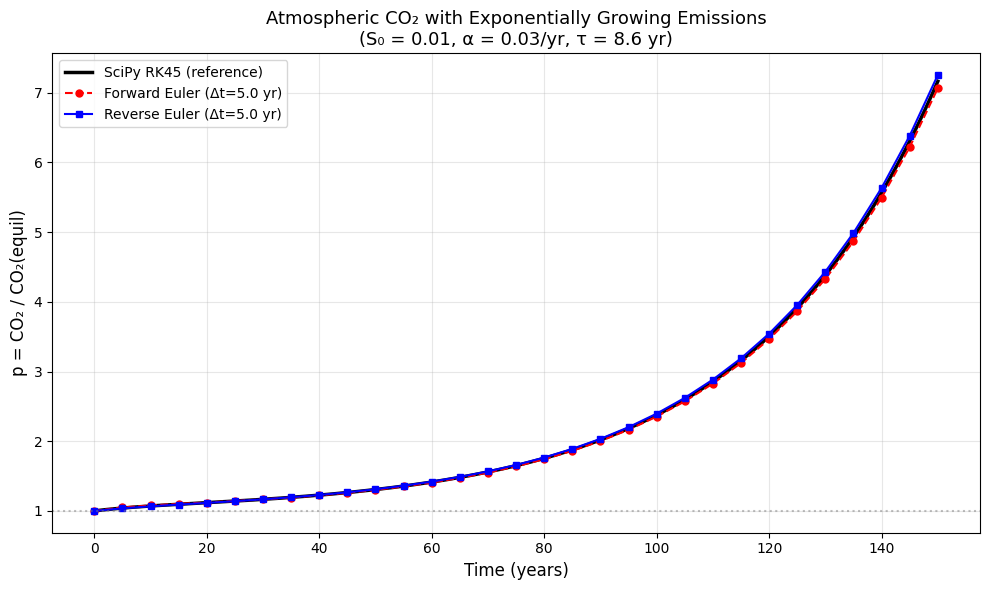

In [7]:
# Exercise 2.3: CO2 exchange with growing fossil fuel emissions

def dpdt_with_source(t, p, tau, S0, alpha):
    """dp/dt = (1-p)/tau + S(t), where S(t) = S0 * exp(alpha*t)"""
    return (1.0 - p) / tau + S0 * np.exp(alpha * t)

def forward_euler_source(p0, tau, dt, t_end, S0, alpha):
    t = np.arange(0, t_end + dt, dt)
    p = np.zeros_like(t)
    p[0] = p0
    for n in range(len(t) - 1):
        S = S0 * np.exp(alpha * t[n])
        p[n+1] = p[n] + dt * ((1.0 - p[n]) / tau + S)
    return t, p

def reverse_euler_source(p0, tau, dt, t_end, S0, alpha):
    """Reverse Euler with source term.
    p_{n+1} = p_n + dt*((1 - p_{n+1})/tau + S(t_{n+1}))
    => p_{n+1}(1 + dt/tau) = p_n + dt/tau + dt*S(t_{n+1})
    => p_{n+1} = (p_n + dt/tau + dt*S(t_{n+1})) / (1 + dt/tau)
    """
    t = np.arange(0, t_end + dt, dt)
    p = np.zeros_like(t)
    p[0] = p0
    r = dt / tau
    for n in range(len(t) - 1):
        S_next = S0 * np.exp(alpha * t[n+1])
        p[n+1] = (p[n] + r + dt * S_next) / (1.0 + r)
    return t, p

# Parameters
S0 = 0.01     # initial source strength (normalised)
alpha = 0.03  # 3% annual growth rate
p0_source = 1.0  # start at equilibrium
t_end_source = 150.0

# SciPy reference
sol_src = solve_ivp(dpdt_with_source, [0, t_end_source], [p0_source],
                    args=(tau, S0, alpha), dense_output=True,
                    rtol=1e-10, atol=1e-12)
t_ref = np.linspace(0, t_end_source, 500)
p_ref = sol_src.sol(t_ref)[0]

dt = 5.0
t_f, p_f = forward_euler_source(p0_source, tau, dt, t_end_source, S0, alpha)
t_r, p_r = reverse_euler_source(p0_source, tau, dt, t_end_source, S0, alpha)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(t_ref, p_ref, 'k-', linewidth=2.5, label='SciPy RK45 (reference)')
ax.plot(t_f, p_f, 'ro--', markersize=5, label=f'Forward Euler (Δt={dt} yr)')
ax.plot(t_r, p_r, 'bs-', markersize=5, label=f'Reverse Euler (Δt={dt} yr)')

ax.axhline(y=1.0, color='gray', linestyle=':', alpha=0.5)
ax.set_xlabel('Time (years)', fontsize=12)
ax.set_ylabel('p = CO₂ / CO₂(equil)', fontsize=12)
ax.set_title('Atmospheric CO₂ with Exponentially Growing Emissions\n'
             f'(S₀ = {S0}, α = {alpha}/yr, τ = {tau:.1f} yr)',
             fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

With a growing source, atmospheric CO₂ rises without bound in this simple model. The exponential growth in emissions eventually overwhelms the ocean sink. This motivates the need for more realistic models with multiple reservoirs and nonlinear ocean chemistry. This is the subjects of Chapters 3 and 4.

---

## References

- Walker, J.C.G. (1991). *Numerical Adventures with Geochemical Cycles*. Oxford University Press.
- Broecker, W.S. and Peng, T.-H. (1982). *Tracers in the Sea*. Eldigio Press, Palisades, New York.